DivS: (divisive)<br>
Divisive suppression explains high-precision firing and contrast adaptation in retinal ganglion cells <br>
url = {https://dx.doi.org/10.7554/elife.19460} <br>

Chou's psi (Subtraction)<br>

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [29]:
import import_ipynb
try:
    os.chdir('Modules')
except:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\retina_python\\Modules')
from time_shifted_PID import MIfunc
from time_shifted_PID import EqualState
from Spike_Generation import SG
from Spike_Generation import NL

In [30]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

# k_E and k_S

In [31]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

In [32]:
m = 4.037925
n =	100
alpha = 8.351984
beta = 3.123359
g =  442.699730/n
tau_y = 0.050404

m = 16.416565
n =	500
alpha = 41.464099
beta = 2.088120
g =  1729.111153/n
tau_y = 0.051583

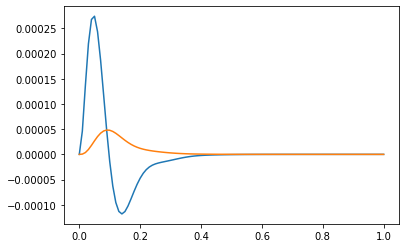

In [33]:
dt = 0.01
TKaxis = np.arange(101)*dt

k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
# y_TK, w_TK = NGD_TK(TKaxis, *[2.67758918, 1.00000000, 1.17089092e+01, 4.69398540, 4.73653606e+02, 2.45547756e-02])
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)

# LPOU input

In [34]:
tot = 1000
Taxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(Taxis))
mu, sigma = 0, 1
for i in range(len(Taxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
x = (LPOU-np.mean(LPOU))/np.std(LPOU)

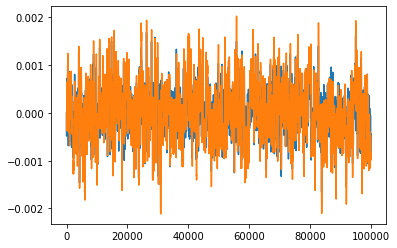

In [35]:
eOutput = np.convolve(x, k_E, 'full')[:len(x)]
sOutput = np.convolve(x, k_S, 'full')[:len(x)]

plt.plot(eOutput)
plt.plot(sOutput)

In [36]:
oriOutput = [eOutput.copy(), sOutput.copy()]
np.std(sOutput)/np.std(eOutput)

1.2907715065468723

# DivS

In [37]:
def f_E(input, boundary):
    if min(input) < -boundary or max(input) > boundary:
        return -1
    return -(input+boundary)/(2*boundary)+1
def f_S(input, boundary):
    if min(input) < -boundary or max(input) > boundary:
        return -1
    p_input = (input+np.abs(input))/2
    p_input = (p_input)/boundary*2
    n_input = (input-np.abs(input))/2
    n_input = (n_input)/boundary*3

    p_output = 1/(1+p_input**3.2)
    n_output = 1/(1+np.abs(n_input)**3.2)
    return p_output+n_output-1

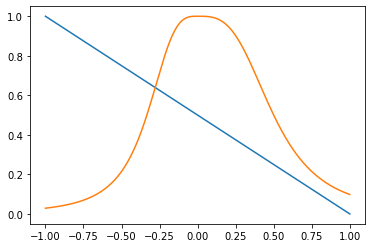

In [38]:
axis = np.linspace(-1,1,1000)
plt.plot(axis, f_E(axis, 1))
plt.plot(axis, f_S(axis, 1))

In [39]:
Output = f_E(eOutput, max(np.abs(eOutput))) * f_S(sOutput, max(np.abs(sOutput)))

(45000.0, 55000.0)

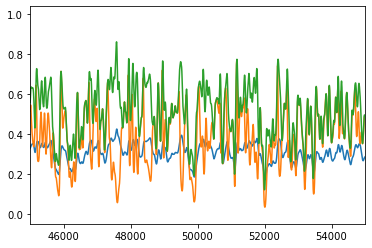

In [40]:
plt.plot(-x*0.05+0.3)
plt.plot(Output)
plt.plot(f_E(eOutput, max(np.abs(eOutput))))
plt.xlim(45000, 55000)

(45000.0, 55000.0)

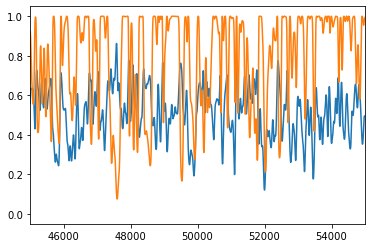

In [41]:
plt.plot(f_E(eOutput, max(np.abs(eOutput))))
plt.plot(f_S(sOutput, max(np.abs(sOutput))))
plt.xlim(45000, 55000)

In [42]:
window = [-1,1]
state_num = 6
xstate = EqualState(LPOU, state_num)[0]

rstate = SG(-eOutput, dt, 0, 10, 10)
timeshift, baseMI = MIfunc(rstate, xstate, dt, window, perSpike = True)

rstate = SG(Output, dt, 0, 10, 10)
timeshift, HC_MI = MIfunc(rstate, xstate, dt, window, perSpike = True)

r = -eOutput
r = NL(r, np.mean(r))
Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
baseXcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]

r = Output
r = NL(r, np.mean(r))
Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
HC_Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]

In [43]:
# plt.plot(timeshift, baseMI)
# plt.plot(timeshift, HC_MI)

## different Contrast

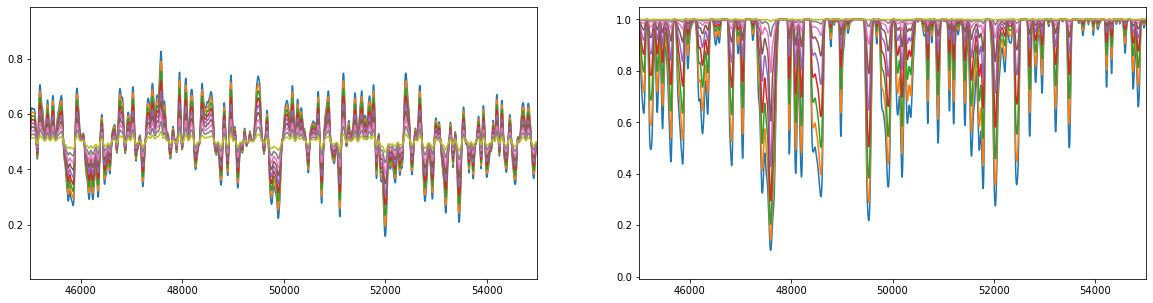

In [44]:
c_ratio_list = np.arange(0.9, 0.0, -0.1)
dC_Output_list = []
fig, ax = plt.subplots(1,2)
for c_ratio in c_ratio_list:
    eOutput_c = f_E(eOutput*c_ratio, max(np.abs(eOutput)))
    sOutput_c = f_S(sOutput*c_ratio, max(np.abs(sOutput)))
    ax[0].plot(eOutput_c)
    ax[1].plot(sOutput_c)
    dC_Output_list.append(eOutput_c*sOutput_c)
for axi in ax:
    axi.set_xlim(45000, 55000)
fig.set_size_inches(20,5)

(45000.0, 55000.0)

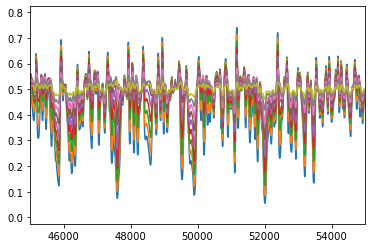

In [45]:
for dC_Output in dC_Output_list:
    plt.plot(dC_Output)
plt.xlim(45000, 55000)

In [46]:
dC_Xcorr = [0]*len(c_ratio_list)
for i in range(len(c_ratio_list)):
    r = dC_Output_list[i] 
    r = NL(r, np.mean(r))
    Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    dC_Xcorr[i] = Xcorr.copy()

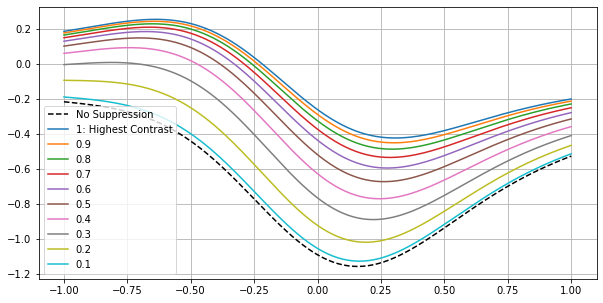

In [47]:
plt.plot(timeshift,baseXcorr, 'k--', label='No Suppression')
plt.plot(timeshift,HC_Xcorr, label='1: Highest Contrast')
for i in range(len(c_ratio_list)): 
    plt.plot(timeshift,dC_Xcorr[i], label=str(round(c_ratio_list[i],3)))
plt.legend()
plt.grid('on')
plt.gcf().set_size_inches(10,5)

In [48]:
dC_MI = [0]*len(c_ratio_list)
for c in range(len(c_ratio_list)):
    rstate = SG(dC_Output_list[c], dt, 0, 10, 10)
    timeshift, dC_MI[c] = MIfunc(rstate, xstate, dt, window, perSpike = True)

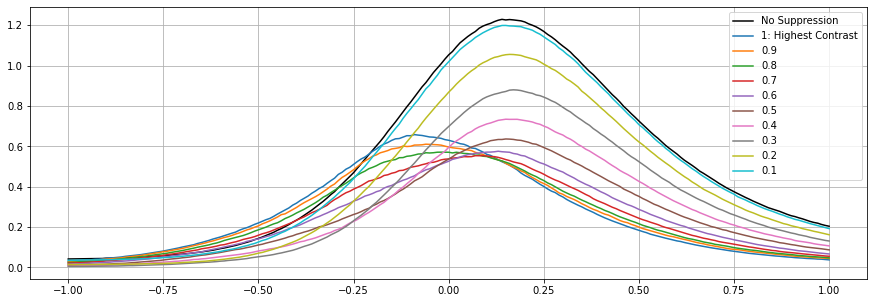

In [49]:
plt.plot(timeshift, baseMI, 'k', label='No Suppression')
plt.plot(timeshift, HC_MI, label='1: Highest Contrast')
for c in range(len(c_ratio_list)):
    plt.plot(timeshift, dC_MI[c], label=str(round(c_ratio_list[c],3)))

plt.legend(loc='best')
plt.grid()
plt.gcf().set_size_inches(15,5)

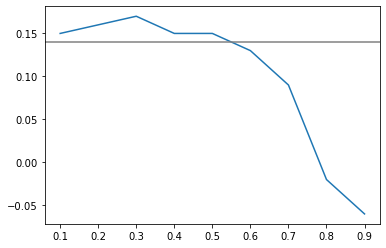

In [50]:
precede = [timeshift[np.argmax(MI)] for MI in dC_MI]

plt.plot(c_ratio_list, precede)
plt.axhline( timeshift[np.argmax(baseMI)], c ='gray' )

# Saving Data

In [51]:
name = 'DivS'

legend = ['C* = 1'] + ['C*='+str(np.round(C,2)) for C in c_ratio_list]

In [52]:
MI_Data = {}
STA_Data = {}
MI_Data['timeshift'] = timeshift
STA_Data['timeshift'] = timeshift

i=0
MI_Data[legend[i]] = HC_MI
for MI in dC_MI:
    i += 1
    MI_Data[legend[i]] = MI

    
i=0
STA_Data[legend[i]] = HC_Xcorr
for Xcorr in dC_Xcorr:
    i += 1
    STA_Data[legend[i]] = Xcorr

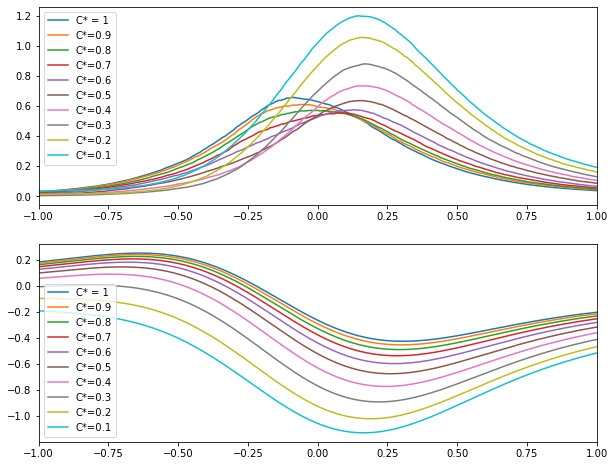

In [55]:
fig, ax = plt.subplots(2,1)
cmind=0
for i in range(len(c_ratio_list)+1):
    ax[0].plot(MI_Data['timeshift'], MI_Data[legend[i]], label = legend[i], color = plt.cm.tab10(cmind))
    ax[1].plot(MI_Data['timeshift'], STA_Data[legend[i]], label = legend[i], color = plt.cm.tab10(cmind))
    cmind += 1


for axi in ax.flatten():
    axi.legend()
    axi.set_xlim([-1,1])
fig.set_size_inches(10, 8)

In [56]:
MI_data_df = pd.DataFrame(MI_Data)
STA_data_df = pd.DataFrame(STA_Data)
with pd.ExcelWriter('D:\\GoogleDrive\\retina\\ContrastPaper\\4OriginPlot\\'+name+'.xlsx') as writer:
    MI_data_df.to_excel(writer,'MI',float_format='%.6f') # float_format 控制精度
    STA_data_df.to_excel(writer,'STA',float_format='%.6f') # float_format 控制精度